In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from model import Model
from simulation import FDTD_sim
from sources import *
from analysis import get_dB_response, get_frequency_response
from io_util import load_from_file, save_to_file

c:\Users\buijs\Documents\TUDelft\Masters Thesis\MEP_refactored\.venv\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


0.007


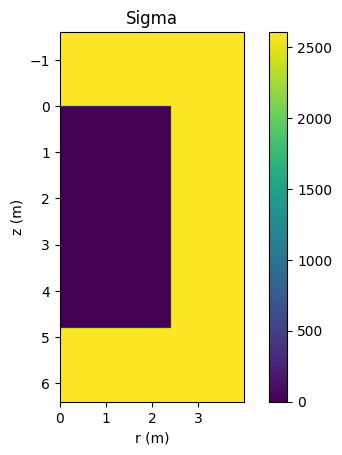

In [2]:
scaleX = 1
scaleT = 1

# Create model
nr = int(1000*scaleX)        # grid points in x - 500
nz = int(2000*scaleX)        # grid points in z - 500
nt = int(7000*scaleT)       # number of time steps
dr = 0.4e-2/scaleX        # grid increment in x in (m) - 10e-3
dz = dr        # grid increment in x in (m) - 
dt = 0.085e-5/scaleT     # Time step in (s) - 2.2e-6
c0 = 1500.0     # velocity in (m/s)
beta = 3.5        # coefficient of nonlinearity  (3.5 for water)
rho0 = 1e3      # density in (kg/m3)

# Diffusivity parameters
mu = 0.9e-3  # Pa * s
muB = 2.47e-3  # Pa * s
k = 0.6  # W / (m * K)
cv = 4.16e3  # J / (kg * K)
cp = 4.18e3  # J / (kg * K)
# diffusivity = 1/rho0*(mu*4/3 + muB) + k/rho0*(1/cv-1/cp)
diffusivity = 0.007  # verweij bachelor ding
# diffusivity = 0
print(diffusivity)

model = Model(nr, nz, nt, dr, dz, dt, c0, beta, rho0, diffusivity)

# Set PML mask
width = int(400*scaleX)  # width must be at least one wavelength (also for the subharmonic)
# width = int(400*scaleX)  # width must be at least one wavelength (also for the subharmonic)
# width = 63
pml_mask = np.zeros((nr, nz))
# pml_mask[nz-100:,:] = 1
# pml_mask[:width, :, :] = 1

pml_mask[nr-width:, :] = 1
pml_mask[:, :width] = 1
pml_mask[:, nz-width:] = 1

# pml_mask[nz//2-20:nz//2+20, nx//2-20:nx//2+20] = 1

model.set_pml_mask(pml_mask, sigma_scaling=0, pml_width=width)
model.sigma *= 10/width/1.8
model.plot(axis_label="space")

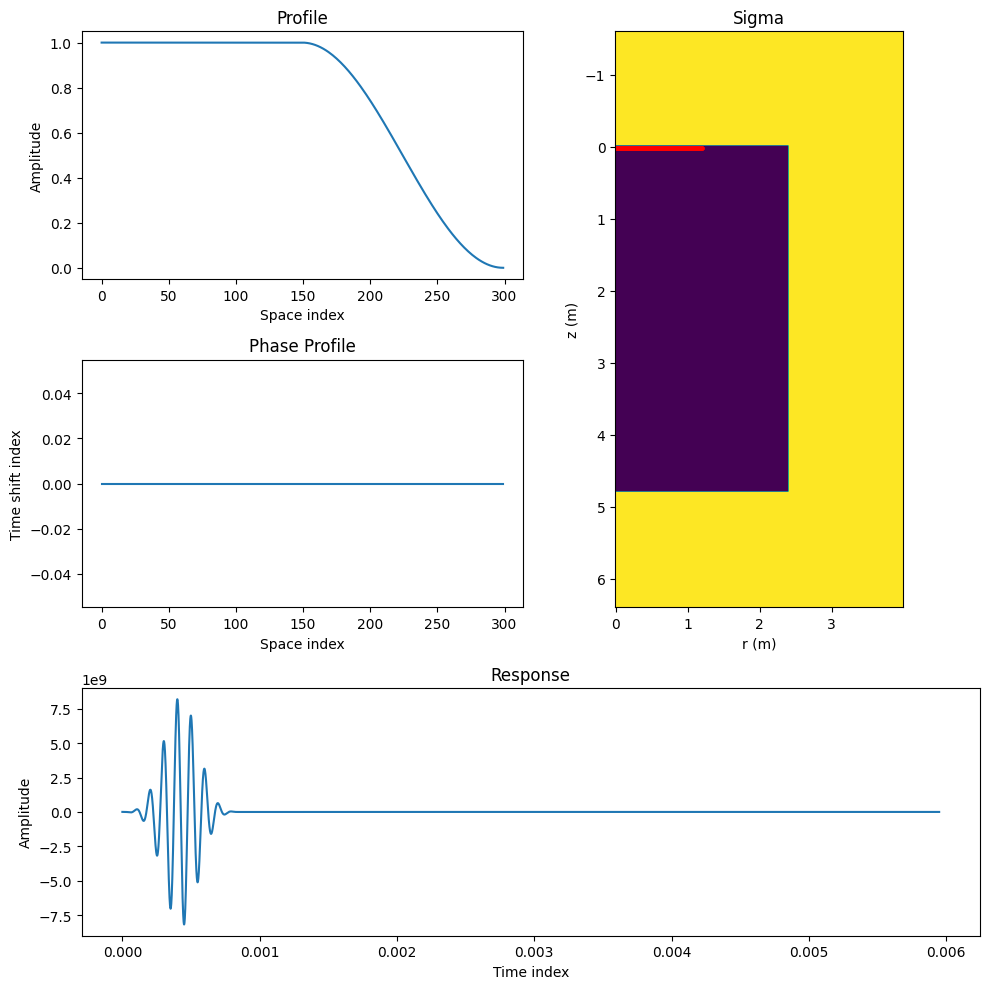

In [3]:
# Create source
# source_width_x = nx // 10
source_width = int(1.2 / dr)

isr = 0  # source index x - nx // 2
isz = width+5     # source index z - 5
# isz = nz//2
f0 = 10e3     # dominant frequency of source (Hz)
omega0 = 2*np.pi*f0
amplitude = 10e5*scaleT  # (Pa)
# pulse_width = 5e6
pulse_width = int(1000*scaleT)
ist = 0     # shifting of source time function
# pulse_width = int(5e6*scaleT)
# ist = 300

delta_f = 10e3

source = CosineSource(isr, isz, source_width, amplitude, f0, nt, dt, dr, dz, ist, pulse_width)
# source = SimpleSource(isx, isy, isz, source_width_x, source_width_y, amplitude, f0, nt, dt, dx, ist)
# source = ParametricSource(isr, isz, source_width, amplitude, f0-delta_f/2, f0+delta_f/2, nt, dt, dr, dz, ist, pulse_width)
source.profile = source.generate_profile(alpha=0.5)
# source = CosineSource(isx, isy, isz, source_width_x, source_width_y, amplitude, f0, nt, dt, dx, ist, pulse_width)
# source.set_focus(20, 0, 30, c0)

source.plot_info(model=model)


In [4]:
# Run simulation
sim = FDTD_sim(model=model, subsample_space=2, subsample_time=2)
sim.add_source(source)

isnap = 1

result = sim.run_simulation_cuda(type="nonlinear")

100%|██████████| 7000/7000 [01:07<00:00, 103.61it/s]


In [5]:
# Use file browser to get file path
result_loaded = load_from_file()
if result_loaded is not None:
    result = result_loaded
    
    # unpack model dimensions
    model = result.model
    nr = result.model.nr
    nz = result.model.nz
    nt = result.model.nt
    dr = result.model.dr
    dz = result.model.dz
    dt = result.model.dt
    
    if result.sources[0].__class__.__name__ == "ParametricSource":
        delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
    
print(model)

print(result.p.shape)
print(f"result.p: {result.p.nbytes/1e6} MB")
# del result

No file selected. Exiting...
Model:
  nr=2000
  nz=5000
  dr=0.004 m
  dz=0.004 m
  nt=16500
  dt=8.5e-07 s
  domain_r=6.392 m
  domain_z=16.8 m
  pml_width=400 / 1.6 m
(5501, 160, 420)
result.p: 1478.6688 MB


620589.0


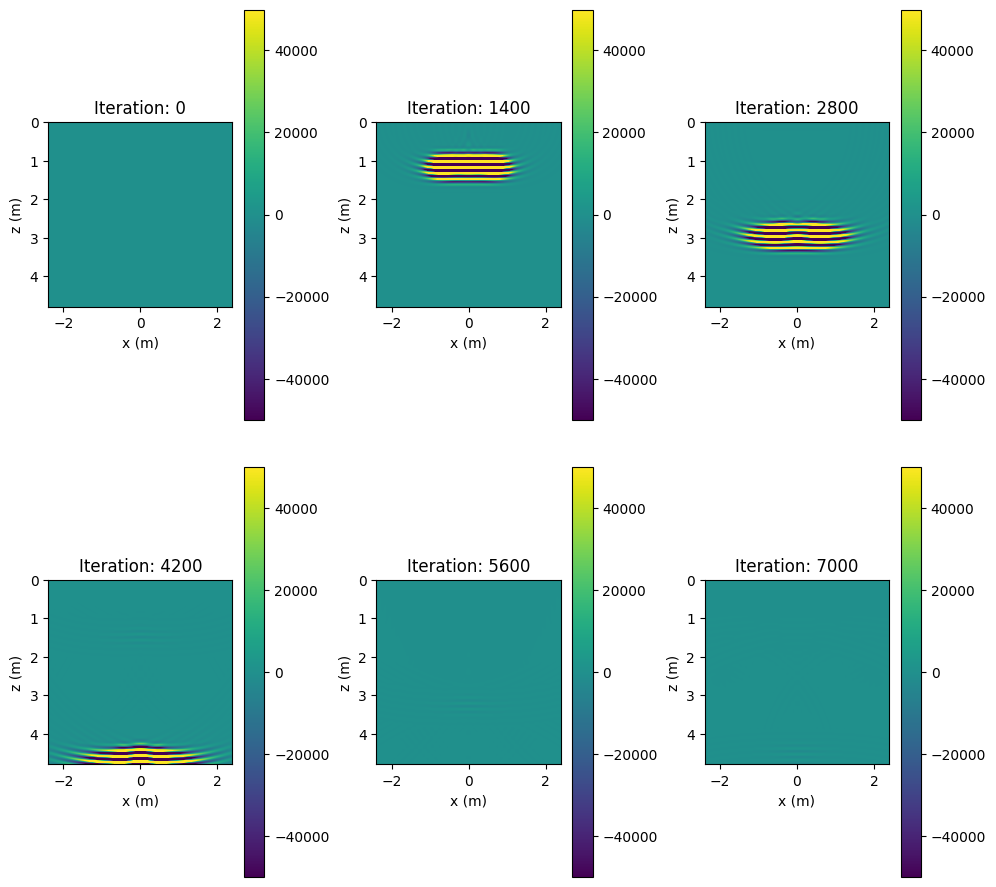

In [5]:
# print(result.p[nt-1, :, ny//2, :].max())
print(result.p.max())
vlimit = result.sources[0].amplitude*1/4/5
result.plot_snapshots(vlimit=vlimit, mirror=True, title_type="iteration")
# print(result.p[1500, 2])
# print(result.p[2000, 0] - result.p[2000, 1])
# plt.imshow(result.p[7000].T, vmin=-vlimit, vmax=vlimit)
# print(result.p[5000].max())
# result.plot_snapshots_3d(vlimit=vlimit)
# result_rk4.plot_snapshots()

# idx_to_plot = 500
# vlimit = amplitude/10
# plt.figure()
# plt.imshow(result.p[idx_to_plot, :, ny//2, :].T - result_rk4.p[idx_to_plot, :, ny//2, :].T, vmin=-vlimit, vmax=vlimit)
# plt.colorbar()
# plt.show()

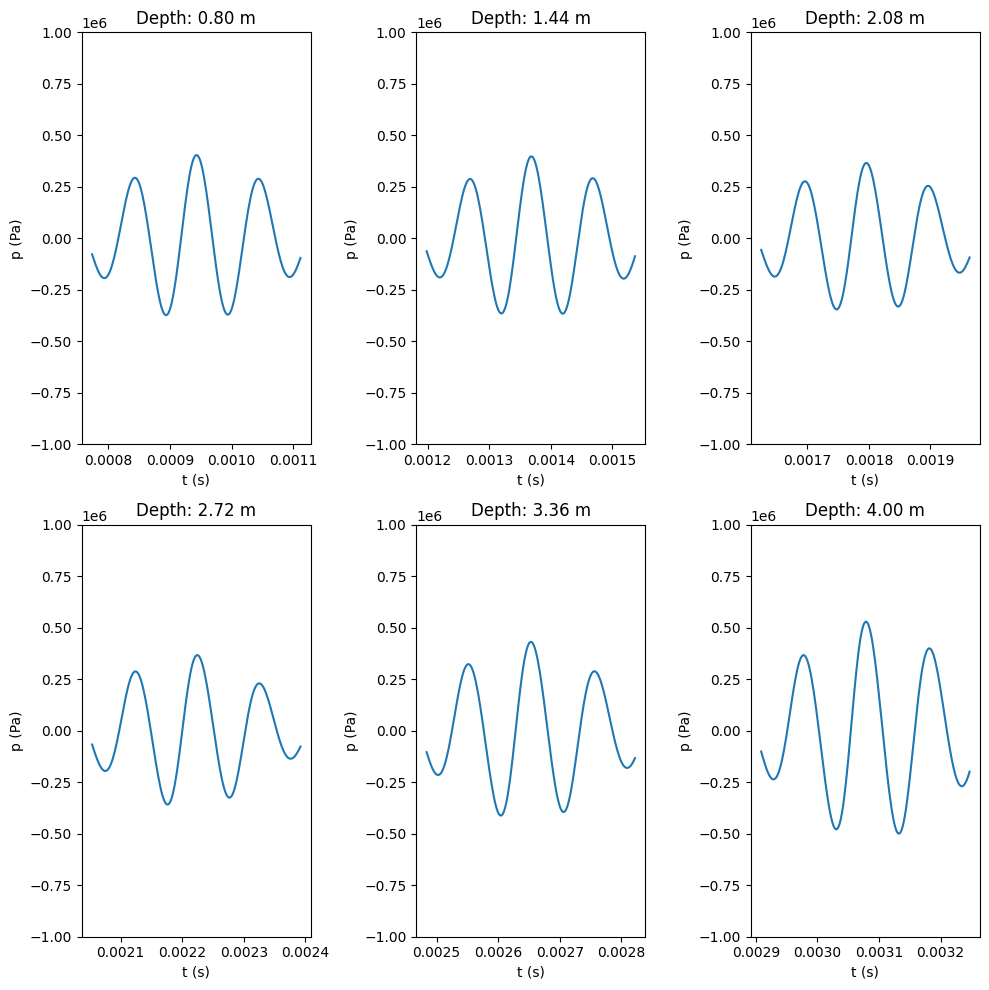

In [6]:
# Plot slice of snapshots
result.plot_slices_time(window_size=100, vlimit=1e6)

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(10, 5))
# vlim = 1e6
# iterations = [1300, 1500, 1700, 1900]
# # plot the wave at 3 different times
# for i in range(2):
#     for j in range(2):
#         idx = iterations[i*2 + j]
#         ax[i, j].plot(np.arange(0,result.p.shape[2])*dz*1, result.p[idx, 0, :].T, label="Pulse")
#         ax[i, j].axvline(nz*dz-width*dz, -0.3e6, 0.3e6, color="k", linestyle="dashed", label="PML boundary")
#         ax[i, j].set_title(f"t = {idx*dt:.2e} s")
#         ax[i, j].set_xlabel("z (m)")
#         ax[i, j].set_ylabel("Pressure (Pa)")
#         ax[i, j].set_xlim(4, 6)
#         ax[i, j].set_ylim(-vlim, vlim)
        
# plt.tight_layout()

In [2]:
result_linear = load_from_file()
result_nonlinear = load_from_file()

383438.1 -380865.7


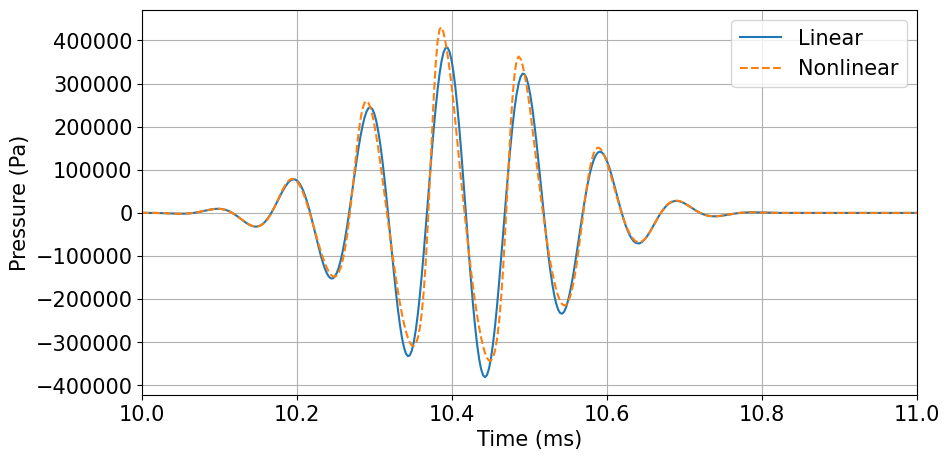

0.0003162 0.020050968750000002


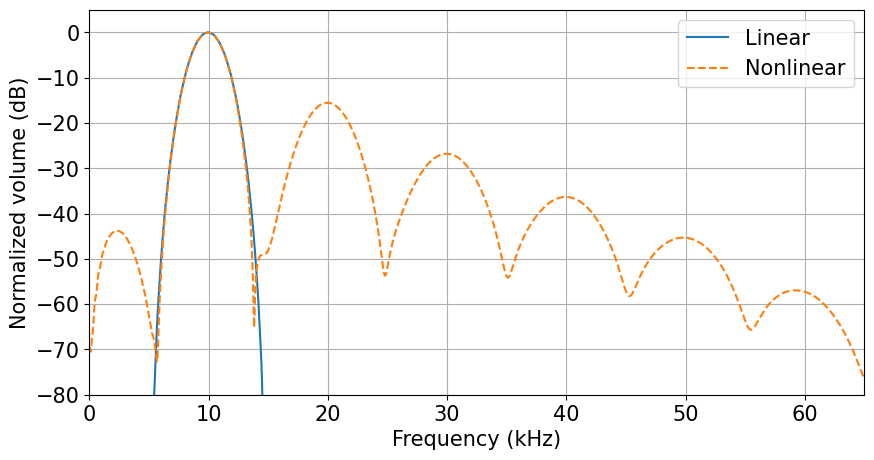

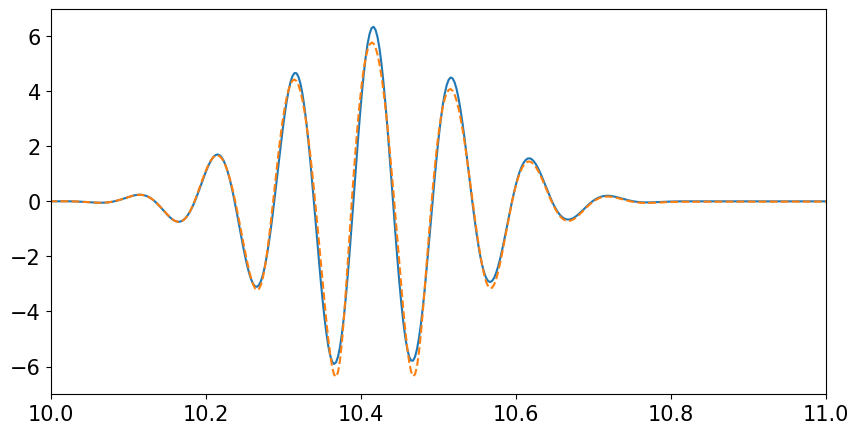

In [37]:
# # Plot the wave at two different depths in one plot
# # depth_indices = [0, result.model.nzd//result.subsample_space-1]
# plt.figure(figsize=(10, 5))
# depths = [0, 4, 7]
# for depth in depths:
#     depth_idx = int(depth / result.model.dz) // result.subsample_space
    
#     time_shift_idx = np.ceil(depth / result.model.c0/ result.model.dt).astype(int)
#     pulse_length = result.sources[0].pulse_length
    
#     pulse = result.p[time_shift_idx:time_shift_idx+pulse_length, 0, depth_idx]
#     pulse_normalized = pulse / pulse.max()
#     np.save(f"pulse_depth{depth:.2f}_linear.npy", pulse)

#     plt.plot(np.linspace(0,1,pulse_length), pulse_normalized)

# plt.ylim(-1.1,1.1)
# plt.grid()

# fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.figure(figsize=(10, 5))
plt.rcParams.update({"font.size": 15})

# pulse_linear = np.load("pulse_depth7.00_linear.npy")
# pulse_nonlinear = np.load("pulse_depth7.00_nonlinear.npy")
z_select = 15
z_idx = int(z_select/result_linear.model.dz/result_linear.subsample_space)
pulse_linear = result_linear.p[:, 0, z_idx]
pulse_nonlinear = result_nonlinear.p[:, 0, z_idx]

# pulse_linear_normalized = pulse_linear / 1e6
# pulse_nonlinear_normalized = pulse_nonlinear / 1e6
pulse_linear_normalized = pulse_linear / pulse_linear.max()
pulse_nonlinear_normalized = pulse_nonlinear / pulse_nonlinear.max()
print(pulse_linear.max(), pulse_linear.min())
# t_axis = np.linspace(0, 1, pulse_linear.shape[0])
t_axis = np.arange(0, pulse_linear.shape[0]) * result_linear.model.dt * result_linear.subsample_time

plt.plot(t_axis*1e3, pulse_linear, label="Linear")
plt.plot(t_axis*1e3, pulse_nonlinear, label="Nonlinear", linestyle="dashed")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Pressure (Pa)")
plt.grid()
# plt.xlim(1.5, 1.85)
# plt.xlim(3.25, 3.75)
t_select = (z_select / result_linear.model.c0)*1e3
# t_select = (z_select / result_linear.model.c0)*1e3 - result_linear.sources[0].pulse_length*result_linear.model.dt*result_linear.subsample_time*1e3
# print(t_select)
plt.xlim(t_select, t_select+1)
# plt.tight_layout()
plt.show()
# ax[0].set_xlim(0, 6.5*10e3)
# ax[0].set_ylim(-0.1,0.1)
print(np.sum(pulse_linear)*result_linear.model.dt*result_linear.subsample_time, np.sum(pulse_nonlinear)*result_linear.model.dt*result_linear.subsample_time)

plt.figure(figsize=(10, 5))

freq_array1, dB_response_linear = get_dB_response(np.pad(pulse_linear, (0,10000)), result_linear.model.dt*result_linear.subsample_time, normalize=True, scaling_factor=result_linear.sources[0].scaling_factor)
freq_array2, dB_response_nonlinear = get_dB_response(np.pad(pulse_nonlinear, (0,10000)), result_linear.model.dt*result_linear.subsample_time, normalize=True, scaling_factor=result_linear.sources[0].scaling_factor)

plt.plot(freq_array1/1e3, dB_response_linear, label="Linear")
plt.plot(freq_array2/1e3, dB_response_nonlinear, label="Nonlinear", linestyle="dashed")
plt.legend()
plt.xlabel("Frequency (kHz)")
plt.ylabel("Normalized volume (dB)")
# plt.xlim(0, 6.5*10e3/1e3)
plt.xlim(0, 6.5*10e3/1e3)
plt.ylim(-80,5)
plt.grid()
# plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t_axis*1e3, np.cumsum(pulse_linear)*result_linear.model.dt*result_linear.subsample_time)
plt.plot(t_axis*1e3, np.cumsum(pulse_nonlinear)*result_linear.model.dt*result_linear.subsample_time, linestyle="dashed")
plt.xlim(t_select, t_select+1)
plt.show()


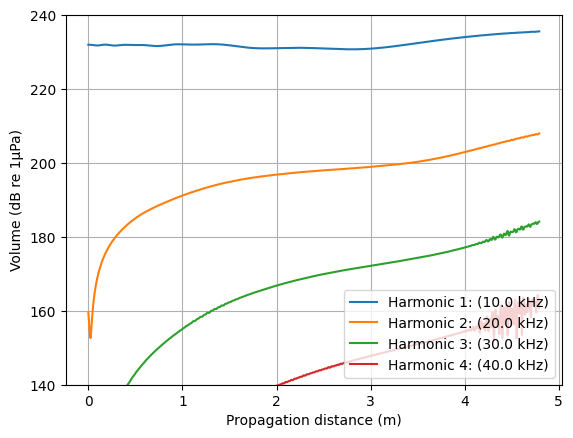

In [7]:
# plt.figure(figsize=(10, 10))

# Generate and plot harmonic progression
nrd = result.p.shape[1]
nzd = result.p.shape[2]

if result.sources[0].__class__.__name__ == "ParametricSource":
    include_subharmonic = True
    delta_f = abs(result.sources[0].frequency1 - result.sources[0].frequency2)
else:
    include_subharmonic = False
    # delta_f = 0

distances, harmonic_progression_array, harmonics = result.harmonic_progression(num_harmonics=4,
                                                         r_start=0,
                                                         z_start=0,
                                                         angle=0,
                                                         include_subharmonic=include_subharmonic,
                                                         subharmonic_freq=delta_f,
                                                         scaling_factor = result.sources[0].scaling_factor*result.subsample_time,
                                                         normalize=False)
if include_subharmonic:
    plt.plot(distances, harmonic_progression_array[0], label=f"Subharmonic: ({delta_f/1e3} kHz)")
    for i in range(1, harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i}: ({harmonics[i]/1e3} kHz)")
else:
    for i in range(harmonic_progression_array.shape[0]):
        plt.plot(distances, harmonic_progression_array[i], label=f"Harmonic {i+1}: ({harmonics[i]/1e3} kHz)")

plt.xlabel("Propagation distance (m)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
# plt.ylim(-100,5)
plt.ylim(140, 240)
# plt.xlim(0, result.model.nzd*result.model.dz)

# plt.xlim(0, 20)

# plt.xlim(350,900)
plt.grid()
# plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.legend(loc="lower right")

# plt.rcParams.update({"font.size": 15})

plt.show()

AttributeError: 'CosineSource' object has no attribute 'frequency1'

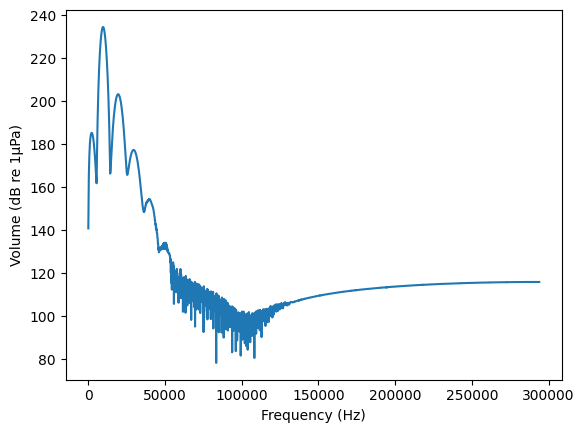

In [8]:
depth = 4  # m
ymin = 100
ymax = 240
# ymin = -100
# ymax = 5

r_index = 0
z_index = int(depth/dz/result.subsample_space)

plt.plot(*get_dB_response(np.pad(result.p[:, r_index, z_index], (0,0)), 
                          result.model.dt*result.subsample_time, 
                          result.sources[0].scaling_factor*result.subsample_time, 
                          normalize=False))
# plt.vlines(delta_f, ymin, ymax, "tab:blue", "--", alpha=1)

# colors = ["w", "tab:orange", "tab:green", "tab:red", "tab:purple"]
# for i in range(1,5):
#     plt.vlines(harmonics[i], ymin, ymax, colors[i], "--", alpha=1)


plt.xlabel("Frequency (Hz)")
# plt.ylabel("Normalized volume (dB)")
plt.ylabel("Volume (dB re 1\u00B5Pa)")
# plt.xlim(0,4*result.sources[0].frequency1)
plt.xlim(0,5.5*result.sources[0].frequency1)
# plt.xlim(0,100000)
plt.ylim(ymin,ymax)
# plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
plt.grid()
plt.show()

In [10]:
result.generate_gif("images/gifs/test.gif", fps=10, frame_interval=100, vlimit=vlimit/10)
# result.generate_gif_3d("gifs/3d_array.gif", fps=20, frame_interval=10, vlimit=vlimit, cmap="jet")

 88%|████████▊ | 14/16 [00:00<00:00, 42.85it/s]

In [9]:
frequencies, lobes_array = result.get_lobes_all(scaling_factor=result.sources[0].scaling_factor, subsample=1)
# frequencies, lobes_array = result.get_lobes_all_split(scaling_factor=result.sources[0].scaling_factor, subsample=3)

Array too large for GPU. Setting subsample to 3.


10000.0


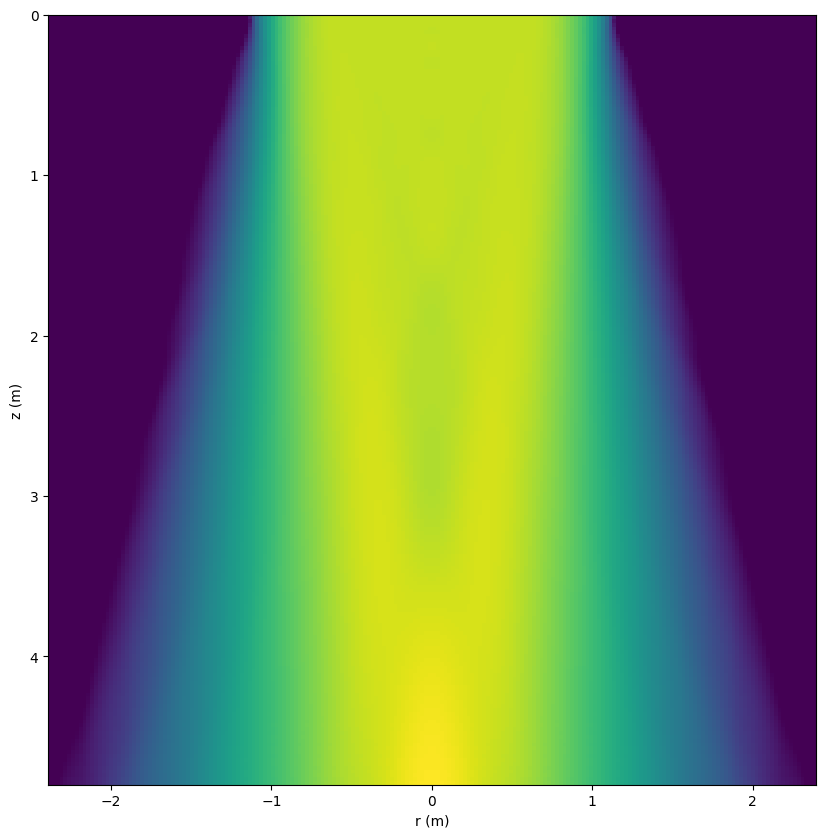

In [10]:
delta_f = 10e3

# freq_to_plot = 1*f0
freq_to_plot = 1*delta_f
# freq_to_plot = result.sources[0].frequency1
# freq_to_plot = 10e3
print(freq_to_plot)
idx = np.argmin(np.abs(frequencies - freq_to_plot))
# lobes_selection = lobes_array[idx]
lobes_selection = lobes_array[idx][:int(20/result.model.dr/result.subsample_space), :int(40/result.model.dz/result.subsample_space)]
# print(frequencies[idx])

normalized = True

vmin = -40
vmax = 0
# vmin = 190
# vmax = 230

# vmin = 150
# vmax = 190
# vmin = None
# vmax = None
lobes_selection = 20*np.log10(lobes_selection/1e-6)

if normalized:
    lobes_selection -= lobes_selection.max()

lobes_selection_mirrored = np.concatenate([np.flip(lobes_selection, axis=0), lobes_selection], axis=0)

fig = plt.figure(figsize=(10, 10))
plt.imshow(lobes_selection_mirrored.T, extent=[-model.nrd * model.dr, model.nrd * model.dr, model.nzd * model.dz, 0], vmin=vmin, vmax=vmax)

# plt.imshow(lobes_selection_mirrored.T, extent=[-20, 20, 40, 0], vmin=vmin, vmax=vmax)
# plt.imshow(lobes_selection_mirrored, extent=[0, model.nzd * model.dz, -model.nrd * model.dr, model.nrd * model.dr], vmin=vmin, vmax=vmax)

# import matplotlib.patches as patches
# rect = patches.Rectangle((-20, 40), 40, -39.8, linewidth=2, linestyle="dashed", edgecolor="tab:red", facecolor="none")
# plt.gca().add_patch(rect)

# cbar = plt.colorbar()
# # cbar = plt.colorbar(shrink=0.4)
# if normalized:
#     cbar.set_label("Normalized volume (dB)")
# else:
#     cbar.set_label("Volume (dB re 1\u00B5Pa)")

plt.xlabel("r (m)")
plt.ylabel("z (m)")
plt.rcParams.update({"font.size": 20})
# plt.tight_layout()
# plt.xlabel("z (m)")
# plt.ylabel("r (m)")

# plt.ylim(120, 0)
# plt.xlim(-40,40)
# print(lobes_selection.T[:,0])

In [7]:
# Save result
save_to_file(result)